In [1]:
# Parameters
n_latent = 50
batch = "chemistry"
annotation = "Level2"


In [2]:
for v in ['n_latent','batch', 'annotation']:
    if v in locals() or v in globals():
        print(f"{v} = {eval(v)}")
    else:
        raise ValueError(f"{v} is not defined")

n_latent = 50
batch = chemistry
annotation = Level2


In [3]:
import os
import sys

import random 
import numpy as np
import matplotlib.pyplot as plt

import scanpy as sc
import scvi
import scgen

import torch
from lightning.pytorch.loggers import CSVLogger

import pandas as pd

import session_info
import warnings
from pyprojroot.here import here

torch.set_float32_matmul_precision('medium')

random_seed = 42

#scvi.settings.dl_num_workers = 8
scvi.settings.seed = random_seed
print("scvi-tools version:", scvi.__version__)

Seed set to 42


scvi-tools version: 1.1.2


## Loading main adata

In [4]:
here()

PosixPath('/scratch_isilon/groups/singlecell/shared/projects/Inflammation-PBMCs-Atlas')

In [5]:
adataM = sc.read_h5ad(here("03_downstream_analysis/02_gene_universe_definition/results/04_MAIN_geneUniverse.log1p.h5ad"))
adataM

AnnData object with n_obs × n_vars = 4435922 × 8253
    obs: 'studyID', 'libraryID', 'sampleID', 'chemistry', 'disease', 'sex', 'binned_age', 'Level1', 'Level2'
    var: 'hgnc_id', 'symbol', 'locus_group', 'HUGO_status', 'highly_variable'
    uns: 'log1p'

### scGen preprocessing

In [6]:
adataM.obs['batch'] = adataM.obs[batch].tolist()
adataM.obs['cell_type'] = adataM.obs[annotation].tolist()
scgen.SCGEN.setup_anndata(adataM, batch_key="batch", labels_key="cell_type")

#### scGen parameters

In [7]:
scgen_model_params = dict({
    'n_latent': n_latent,
    'n_hidden': 800,
    'n_layers': 3,
    'dropout_rate': 0.2,
})

In [8]:
train_params = dict({
    'max_epochs':1000,
    'batch_size':128, 
    'early_stopping': True, 
    'early_stopping_patience':5, 
    'log_every_n_steps':10000,
    #'plan_kwargs':dict({'lr':0.001}) # default learning rate
})

In [9]:
model_scGen = scgen.SCGEN(adataM, **scgen_model_params)
model_scGen.view_anndata_setup()

Anndata setup with scvi-tools version 1.1.2.

Setup via `SCGEN.setup_anndata` with arguments:

{'batch_key': 'batch', 'labels_key': 'cell_type'}

      Summary Statistics      
┏━━━━━━━━━━━━━━━━━━┳━━━━━━━━━┓
┃ Summary Stat Key ┃  Value  ┃
┡━━━━━━━━━━━━━━━━━━╇━━━━━━━━━┩
│     n_batch      │    4    │
│     n_cells      │ 4435922 │
│     n_labels     │   64    │
│      n_vars      │  8253   │
└──────────────────┴─────────┘

               Data Registry                
┏━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Registry Key ┃    scvi-tools Location    ┃
┡━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│      X       │          adata.X          │
│    batch     │ adata.obs['_scvi_batch']  │
│    labels    │ adata.obs['_scvi_labels'] │
└──────────────┴───────────────────────────┘

                  batch State Registry                   
┏━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┓
┃  Source Location   ┃ Categories ┃ scvi-tools Encoding ┃
┡━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━┩
│ adata.obs['batch'] │  3_GEX_V2  │          0          │
│                    │  3_GEX_V3  │          1          │
│                    │  5_GEX_V1  │          2          │
│                    │  5_GEX_V2  │          3          │
└────────────────────┴────────────┴─────────────────────┘

                         labels State Registry                         
┏━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┓
┃    Source Location     ┃      Categories      ┃ scvi-tools Encoding ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━┩
│ adata.obs['cell_type'] │    B_IFNresponder    │          0          │
│                        │    B_Memory_ITGAX    │          1          │
│                        │  B_Memory_switched   │          2          │
│                        │ B_Memory_unswitched  │          3          │
│                        │       B_Naive        │          4          │
│                        │  B_Naive_activated   │          5          │
│                        │    B_Progenitors     │          6          │
│                        │    B_Transitional    │          7          │
│                        │         DC4          │          8          │
│                        │         DC5          │          9          │
│                        │       DC_CCR7        │         10          │
│                        │   DC_Proliferative   │         11          │
│                        │       HSC_LMP        │         12          │
│                        │       HSC_MEMP       │         13          │
│                        │       HSC_MMP        │         14          │
│                        │         MAIT         │         15          │
│                        │       MAIT_17        │         16          │
│                        │   Mono_IFNresponse   │         17          │
│                        │    Mono_classical    │         18          │
│                        │  Mono_inflammatory   │         19          │
│                        │  Mono_nonClassical   │         20          │
│                        │   Mono_regulatory    │         21          │
│                        │     NK_CD16high      │         22          │
│                        │    NK_CD56dimCD16    │         23          │
│                        │     NK_CD56high      │         24          │
│                        │   NK_IFN1response    │         25          │
│                        │   NK_Proliferative   │         26          │
│                        │     NK_adaptive      │         27          │
│                        │  NK_lowRibocontent   │         28          │
│                        │     Plasma_IGHA      │         29          │
│                        │     Plasma_IGHG      │         30          │
│                        │ Plasma_Proliferative │         31          │
│                        │     Plasma_XBP1      │         32          │
│                        │      Platelets       │         33          │
│                        │         RBC          │         34          │
│                        │       T_CD4_CM       │         35          │
│                        │    T_CD4_CM_ribo     │         36          │
│                        │       T_CD4_EM       │         37          │
│                        │      T_CD4_EMRA      │         38          │
│                        │     T_CD4_Naive      │         39          │
│                        │      T_CD4_eff       │         40          │
│                        │       T_CD8_CM       │         41          │
│                        │    T_CD8_CM_stem     │         42          │
│                        │ T_CD8_EM_CX3CR1high  │         43          │
│                        │  T_CD8_EM_CX3CR1int  │         44          │
│                        │  T_CD8_IFNresponse   │         45          │
│                        │ T_CD8_Mem_cytotoxic  │         46          │
│                        │     T_CD8_Naive      │         47          │
│                        │   T_CD8_activated    │         48          │
│                        │    T_CD8_arrested    │         49          │
│                        │   T_CD8_eff_HOBIT    │         50          │
│                        │    T_Progenit

### Training the model

In [10]:
model_scGen.train(**train_params)

GPU available: True (cuda), used: True


TPU available: False, using: 0 TPU cores


IPU available: False, using: 0 IPUs


HPU available: False, using: 0 HPUs


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


/scratch_isilon/groups/singlecell/shared/conda_env/scvi-v112/lib/python3.9/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:441: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=35` in the `DataLoader` to improve performance.
/scratch_isilon/groups/singlecell/shared/conda_env/scvi-v112/lib/python3.9/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:441: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=35` in the `DataLoader` to improve performance.


Training:   0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 1/1000:   0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 1/1000:   0%|          | 1/1000 [08:19<138:30:00, 499.10s/it]

Epoch 1/1000:   0%|          | 1/1000 [08:19<138:30:00, 499.10s/it, v_num=1, train_loss_step=1.3e+3, train_loss_epoch=1.19e+3]

Epoch 2/1000:   0%|          | 1/1000 [08:19<138:30:00, 499.10s/it, v_num=1, train_loss_step=1.3e+3, train_loss_epoch=1.19e+3]

Epoch 2/1000:   0%|          | 2/1000 [16:36<138:07:11, 498.23s/it, v_num=1, train_loss_step=1.3e+3, train_loss_epoch=1.19e+3]

Epoch 2/1000:   0%|          | 2/1000 [16:36<138:07:11, 498.23s/it, v_num=1, train_loss_step=1.28e+3, train_loss_epoch=1.17e+3]

Epoch 3/1000:   0%|          | 2/1000 [16:36<138:07:11, 498.23s/it, v_num=1, train_loss_step=1.28e+3, train_loss_epoch=1.17e+3]

Epoch 3/1000:   0%|          | 3/1000 [24:54<137:53:08, 497.88s/it, v_num=1, train_loss_step=1.28e+3, train_loss_epoch=1.17e+3]

Epoch 3/1000:   0%|          | 3/1000 [24:54<137:53:08, 497.88s/it, v_num=1, train_loss_step=2.5e+3, train_loss_epoch=1.16e+3] 

Epoch 4/1000:   0%|          | 3/1000 [24:54<137:53:08, 497.88s/it, v_num=1, train_loss_step=2.5e+3, train_loss_epoch=1.16e+3]

Epoch 4/1000:   0%|          | 4/1000 [33:11<137:43:20, 497.79s/it, v_num=1, train_loss_step=2.5e+3, train_loss_epoch=1.16e+3]

Epoch 4/1000:   0%|          | 4/1000 [33:11<137:43:20, 497.79s/it, v_num=1, train_loss_step=1.67e+3, train_loss_epoch=1.16e+3]

Epoch 5/1000:   0%|          | 4/1000 [33:11<137:43:20, 497.79s/it, v_num=1, train_loss_step=1.67e+3, train_loss_epoch=1.16e+3]

Epoch 5/1000:   0%|          | 5/1000 [41:23<136:57:59, 495.56s/it, v_num=1, train_loss_step=1.67e+3, train_loss_epoch=1.16e+3]

Epoch 5/1000:   0%|          | 5/1000 [41:23<136:57:59, 495.56s/it, v_num=1, train_loss_step=3.01e+3, train_loss_epoch=1.16e+3]

Epoch 6/1000:   0%|          | 5/1000 [41:23<136:57:59, 495.56s/it, v_num=1, train_loss_step=3.01e+3, train_loss_epoch=1.16e+3]

Epoch 6/1000:   1%|          | 6/1000 [49:41<137:04:43, 496.46s/it, v_num=1, train_loss_step=3.01e+3, train_loss_epoch=1.16e+3]

Epoch 6/1000:   1%|          | 6/1000 [49:41<137:04:43, 496.46s/it, v_num=1, train_loss_step=1.26e+3, train_loss_epoch=1.16e+3]

Epoch 7/1000:   1%|          | 6/1000 [49:41<137:04:43, 496.46s/it, v_num=1, train_loss_step=1.26e+3, train_loss_epoch=1.16e+3]

Epoch 7/1000:   1%|          | 7/1000 [58:00<137:07:30, 497.13s/it, v_num=1, train_loss_step=1.26e+3, train_loss_epoch=1.16e+3]

Epoch 7/1000:   1%|          | 7/1000 [58:00<137:07:30, 497.13s/it, v_num=1, train_loss_step=1.85e+3, train_loss_epoch=1.16e+3]

Epoch 8/1000:   1%|          | 7/1000 [58:00<137:07:30, 497.13s/it, v_num=1, train_loss_step=1.85e+3, train_loss_epoch=1.16e+3]

Epoch 8/1000:   1%|          | 8/1000 [1:06:18<137:06:07, 497.55s/it, v_num=1, train_loss_step=1.85e+3, train_loss_epoch=1.16e+3]

Epoch 8/1000:   1%|          | 8/1000 [1:06:18<137:06:07, 497.55s/it, v_num=1, train_loss_step=1.32e+3, train_loss_epoch=1.16e+3]

Epoch 9/1000:   1%|          | 8/1000 [1:06:18<137:06:07, 497.55s/it, v_num=1, train_loss_step=1.32e+3, train_loss_epoch=1.16e+3]

Epoch 9/1000:   1%|          | 9/1000 [1:14:36<137:00:31, 497.71s/it, v_num=1, train_loss_step=1.32e+3, train_loss_epoch=1.16e+3]

Epoch 9/1000:   1%|          | 9/1000 [1:14:36<137:00:31, 497.71s/it, v_num=1, train_loss_step=2.12e+3, train_loss_epoch=1.15e+3]

Epoch 10/1000:   1%|          | 9/1000 [1:14:36<137:00:31, 497.71s/it, v_num=1, train_loss_step=2.12e+3, train_loss_epoch=1.15e+3]

Epoch 10/1000:   1%|          | 10/1000 [1:22:55<136:57:23, 498.02s/it, v_num=1, train_loss_step=2.12e+3, train_loss_epoch=1.15e+3]

Epoch 10/1000:   1%|          | 10/1000 [1:22:55<136:57:23, 498.02s/it, v_num=1, train_loss_step=1.78e+3, train_loss_epoch=1.15e+3]

Epoch 11/1000:   1%|          | 10/1000 [1:22:55<136:57:23, 498.02s/it, v_num=1, train_loss_step=1.78e+3, train_loss_epoch=1.15e+3]

Epoch 11/1000:   1%|          | 11/1000 [1:31:14<136:55:29, 498.41s/it, v_num=1, train_loss_step=1.78e+3, train_loss_epoch=1.15e+3]

Epoch 11/1000:   1%|          | 11/1000 [1:31:14<136:55:29, 498.41s/it, v_num=1, train_loss_step=2.04e+3, train_loss_epoch=1.15e+3]

Epoch 12/1000:   1%|          | 11/1000 [1:31:14<136:55:29, 498.41s/it, v_num=1, train_loss_step=2.04e+3, train_loss_epoch=1.15e+3]

Epoch 12/1000:   1%|          | 12/1000 [1:39:32<136:45:05, 498.28s/it, v_num=1, train_loss_step=2.04e+3, train_loss_epoch=1.15e+3]

Epoch 12/1000:   1%|          | 12/1000 [1:39:32<136:45:05, 498.28s/it, v_num=1, train_loss_step=2.11e+3, train_loss_epoch=1.15e+3]

Epoch 13/1000:   1%|          | 12/1000 [1:39:32<136:45:05, 498.28s/it, v_num=1, train_loss_step=2.11e+3, train_loss_epoch=1.15e+3]

Epoch 13/1000:   1%|▏         | 13/1000 [1:47:50<136:35:57, 498.23s/it, v_num=1, train_loss_step=2.11e+3, train_loss_epoch=1.15e+3]

Epoch 13/1000:   1%|▏         | 13/1000 [1:47:50<136:35:57, 498.23s/it, v_num=1, train_loss_step=1.75e+3, train_loss_epoch=1.15e+3]

Epoch 14/1000:   1%|▏         | 13/1000 [1:47:50<136:35:57, 498.23s/it, v_num=1, train_loss_step=1.75e+3, train_loss_epoch=1.15e+3]

Epoch 14/1000:   1%|▏         | 14/1000 [1:56:08<136:22:49, 497.94s/it, v_num=1, train_loss_step=1.75e+3, train_loss_epoch=1.15e+3]

Epoch 14/1000:   1%|▏         | 14/1000 [1:56:08<136:22:49, 497.94s/it, v_num=1, train_loss_step=1.74e+3, train_loss_epoch=1.15e+3]

Epoch 15/1000:   1%|▏         | 14/1000 [1:56:08<136:22:49, 497.94s/it, v_num=1, train_loss_step=1.74e+3, train_loss_epoch=1.15e+3]

Epoch 15/1000:   2%|▏         | 15/1000 [2:04:27<136:21:05, 498.34s/it, v_num=1, train_loss_step=1.74e+3, train_loss_epoch=1.15e+3]

Epoch 15/1000:   2%|▏         | 15/1000 [2:04:27<136:21:05, 498.34s/it, v_num=1, train_loss_step=1.28e+3, train_loss_epoch=1.15e+3]

Epoch 16/1000:   2%|▏         | 15/1000 [2:04:27<136:21:05, 498.34s/it, v_num=1, train_loss_step=1.28e+3, train_loss_epoch=1.15e+3]

Epoch 16/1000:   2%|▏         | 16/1000 [2:12:46<136:17:48, 498.65s/it, v_num=1, train_loss_step=1.28e+3, train_loss_epoch=1.15e+3]

Epoch 16/1000:   2%|▏         | 16/1000 [2:12:46<136:17:48, 498.65s/it, v_num=1, train_loss_step=1.69e+3, train_loss_epoch=1.15e+3]

Epoch 16/1000:   2%|▏         | 16/1000 [2:12:46<136:05:51, 497.92s/it, v_num=1, train_loss_step=1.69e+3, train_loss_epoch=1.15e+3]


Monitored metric elbo_validation did not improve in the last 5 records. Best score: 3179.314. Signaling Trainer to stop.


### Plotting loss functions

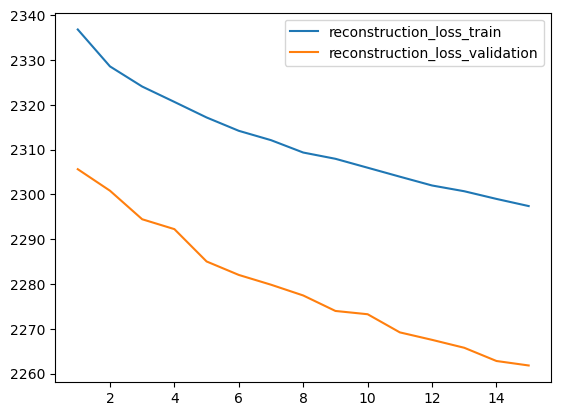

In [11]:
plt.plot(model_scGen.history['reconstruction_loss_train'][1:], label = 'reconstruction_loss_train')
plt.plot(model_scGen.history['reconstruction_loss_validation'][1:], label = 'reconstruction_loss_validation')
plt.title('')
plt.legend()
plt.show()

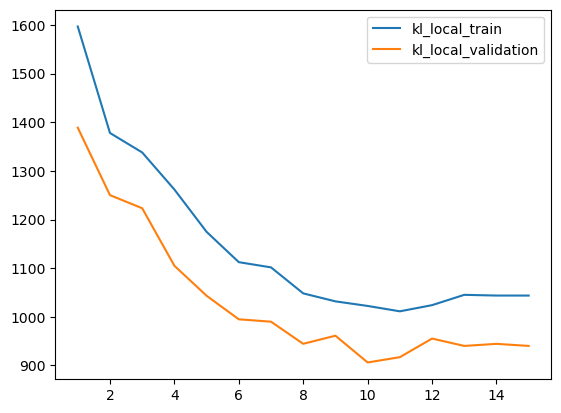

In [12]:
plt.plot(model_scGen.history['kl_local_train'][1:], label = 'kl_local_train')
plt.plot(model_scGen.history['kl_local_validation'][1:], label = 'kl_local_validation')
plt.title('')
plt.legend()
plt.show()

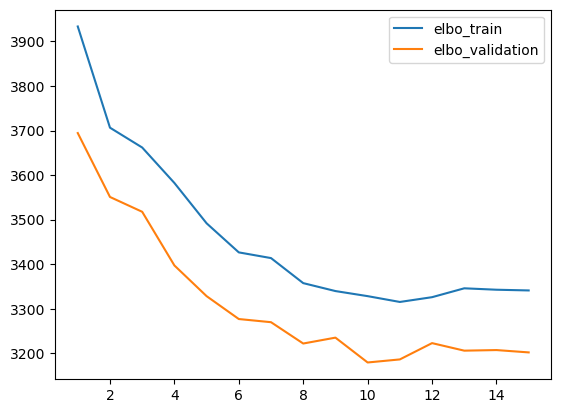

In [13]:
plt.plot(model_scGen.history['elbo_train'][1:], label = 'elbo_train')
plt.plot(model_scGen.history['elbo_validation'][1:], label = 'elbo_validation')
plt.title('')
plt.legend()
plt.show()

### Save the results

**scGen model**

In [14]:
model_scGen.save(here(f"03_downstream_analysis/08_PatientClassifier/scGen/results/01_scGen_train_nLat{n_latent}_{batch}_{annotation}"), 
                 overwrite = True, save_anndata = False)